# Detection of Moving Vehicles in Sentinel-2 Imagery

## Overview
This notebook adapts the innovative approach outlined by Henrik Fisser to infer changes in traffic densities through time series analysis of Sentinel-2 multispectral imagery: https://github.com/hfisser/Truck_Detection_Sentinel2_COVID19. By virtue of its hardware design, Multi-Spectral Instrument (MSI) on-board Sentinel-2A/B exhibits intra-detector parallax angle which leads to sub-pixel shifts between multi-spectral images during acquisition. Typically sub-pixel misregistration is corrected by software running in ground segment pipeline - however preprocessing operation is unable to correct shifts caused by moving and/or high altitude objects. A recent [paper](https://www.sciencedirect.com/science/article/abs/pii/S0034425720302376) mapped global distribution of flying aircraft using Sentinel-2 imagery by identifying 'rainbows' indicative of misalignment between multispectral reflectances captured from moving objects. 

In [1]:
from IPython.display import Video
Video("https://video.twimg.com/tweet_video/EZLSg62UMAUS1Xi.mp4")

## Method
The original approach utilised threshold-based ratios to identify pixels demonstrating a significant shift in 
red (B4), green (B3) and blue (B2) reflectance. Candidate detections were filtered by applying a binary mask to remove false detections from non-road locations. Road mask was generated using standard metrics such as NDVI and NDWI to localise multispectral signatures commonly associated with manmade land surfaces. Initial analysis revealed road mask derivation was highly susceptible to background noise and often unable to accurately delineate road network across a Sentinel-2 scene.

To improve algorithm robustness for potential operational usage, this study generated binary masks to accurately localise road network by rasterising coincident Open Street Map (OSM) vector geometries loaded into [PostGIS](https://postgis.net/) database. Original OSM datasets were downloaded from [Geofabrik](http://www.geofabrik.de/) and imported into PostGIS using [Imposm](https://imposm.org/) toolset. The SQL query listed below was executed to burn underlying vector geometries - buffered by 20m - into empty raster over an specified area of interest (southern UK). Information from Scene Classification Layer (SCL) was also extracted to derive a secondary binary mask to filter out cloud contamination, water and poor quality data.

## Results

In [2]:
# define repo name and get root working directory
import os

repo = 'truck-s2'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]

In [3]:
# add repo source directory to system path
import sys
sys.path.insert(0, os.path.join( root_path, 'src' ) )

In [4]:
# create detector object
from detector import Detector
obj = Detector()

In [5]:
# read reflectance, geo and qa from scene file
scene = os.path.join( root_path, 'data/S2B_MSIL2A_20200531T110619_N0214_R137_T30UXB_20200531T131801.zip' )
data, geo, qa = obj.getDatasets( scene )

In [6]:
# identify candidate pixels with significant shift in red, green and blue reflectance
candidates = obj.getCandidateMap( data )

C:\Users\Chris.Williams\Documents\GitHub\truck-s2\src\detector.py:272: RuntimeWarning: invalid value encountered in true_divide
  bg_ratio = ( data[ 'B2' ] - data[ 'B3' ] ) / ( data[ 'B2' ] + data[ 'B3' ] )
C:\Users\Chris.Williams\Documents\GitHub\truck-s2\src\detector.py:273: RuntimeWarning: invalid value encountered in true_divide
  br_ratio = ( data[ 'B2' ] - data[ 'B4' ] ) / ( data[ 'B2' ] + data[ 'B4' ] )
C:\Users\Chris.Williams\Documents\GitHub\truck-s2\src\detector.py:276: RuntimeWarning: invalid value encountered in greater
  bg_low = bg_ratio > self._min_green_ratio
C:\Users\Chris.Williams\Documents\GitHub\truck-s2\src\detector.py:277: RuntimeWarning: invalid value encountered in greater
  br_low = br_ratio > self._min_red_ratio


In [7]:
# apply mask to candidate detections - filter out cloud, shadows, water and poor quality data
import numpy as np
candidates = np.bitwise_and( candidates, ~qa['MASK'] )

In [8]:
# load OSM derived road mask from file
mask_pathname = os.path.join( root_path, 'data/motorways.tif' )
roads = obj.loadRoadMask( mask_pathname, geo )

In [9]:
# mask candidates with road mask 
candidates = candidates * roads

In [10]:
from skimage.measure import label

# assign object ids to remaining candidate pixels
blobs = label( candidates )
pts = np.nonzero( blobs )

# capture centroid locations of moving objects
x = []; y = []
for blob_id in range( 1, np.max( blobs ) + 1 ):

    idx = np.where( blobs[pts]==blob_id )

    # record mean x, y of detected object
    x.append( np.mean( pts[1][idx] ) )
    y.append( np.mean( pts[0][idx] ) )
    
print ( 'Moving objects detected: {}'.format( len ( x ) ) )

Moving objects detected: 253


In [11]:
# generate 24bit rgb image from floating point reflectances
rgb = obj.getRgbImage( data, [ 'B4', 'B3', 'B2' ] )

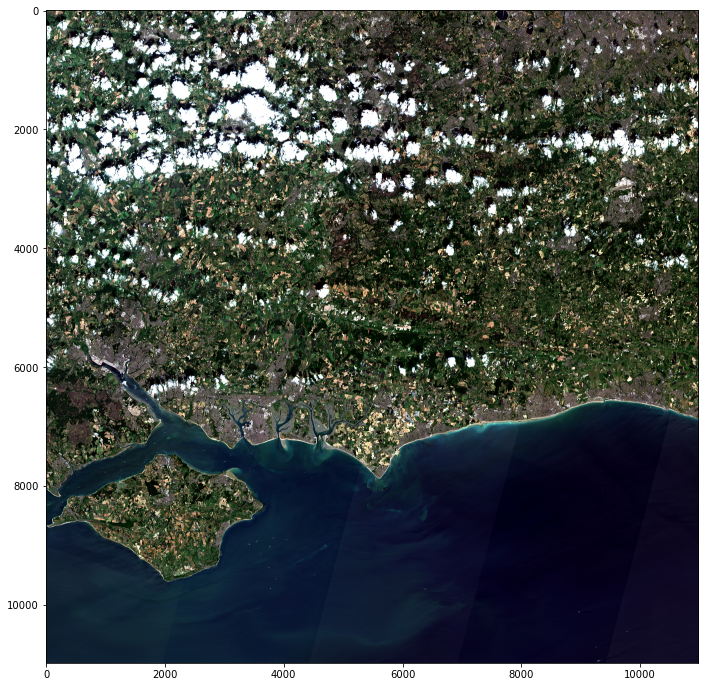

In [12]:
# show rgb image
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
axes.imshow( rgb )
plt.show()

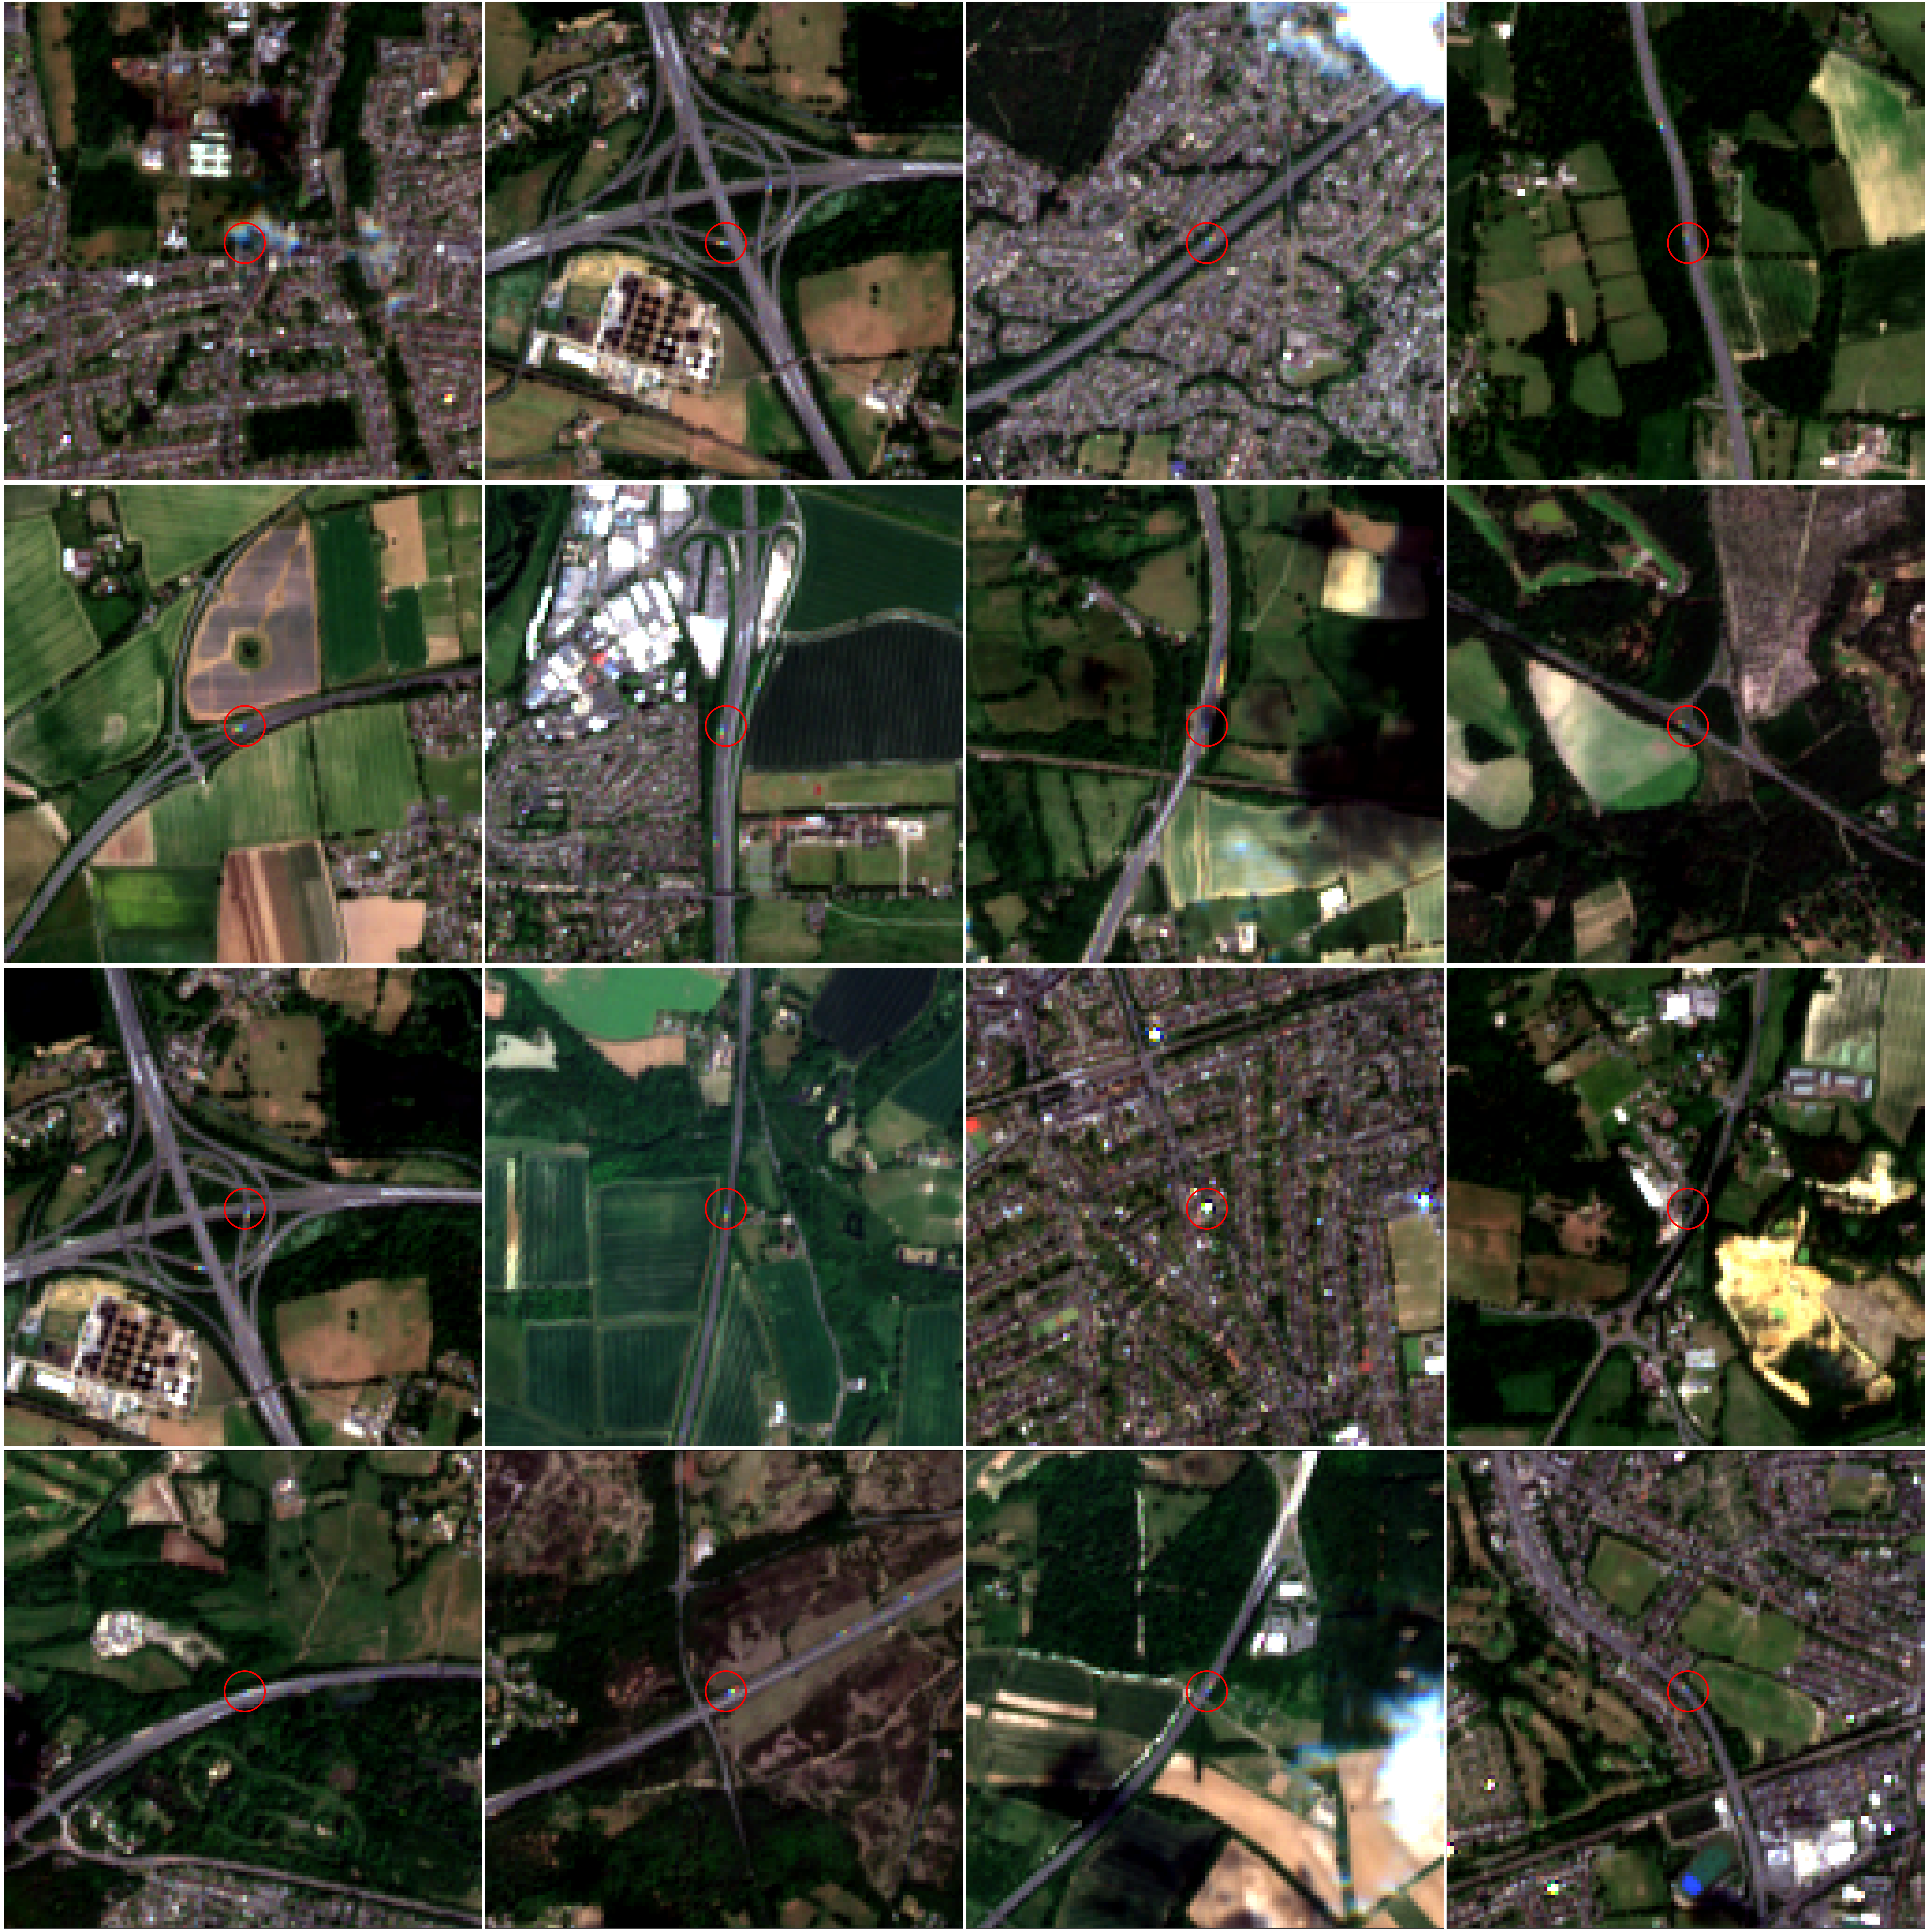

In [16]:
import random

# create plot canvas
nrows = 4; ncols = 4; size = 64
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(80, 80))

# iterate axes
for row in range( nrows ):
    for col in range( ncols ):

        while True:

            # randomly pick candidate location
            idx = random.randrange( len( x ) )
            x1 = int ( x[ idx ] - size ); y1 = int ( y[ idx ] - size )

            # check valid image is plotable
            if y1 > 0 and x1 > 0 and y1 < ( data[ 'B4' ].shape[0] - size ) and x1 < ( data[ 'B4' ].shape[1] - size ):
                break

        # plot rgb subimage
        axes[ row ][ col ].imshow( rgb [ y1: (y1+size*2), x1 : (x1+size*2), : ] )
        axes[ row ][ col ].plot( size, size, 'or', markersize=120, fillstyle='none', markeredgewidth=5 )

        # clear ticks
        axes[ row ][ col ].get_xaxis().set_ticks([])
        axes[ row ][ col ].get_yaxis().set_ticks([])

# tighten up
fig.tight_layout()        
plt.show()
